In [ ]:
!pip install -q opendatasets

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn,VGG16_BN_Weights
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
import PIL
from PIL import Image
from torchvision.transforms import Normalize, ToTensor, Compose
from matplotlib import pyplot as plt
import math
import pandas as pd
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bhardwajdivyanshu
Your Kaggle Key: ··········


100%|██████████| 32.9M/32.9M [00:02<00:00, 12.1MB/s]


In [ ]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

In [ ]:
!ls /content/retina-blood-vessel/Data/train/image

0.png	16.png	22.png	29.png	35.png	41.png	48.png	54.png	60.png	67.png	73.png	7.png
10.png	17.png	23.png	2.png	36.png	42.png	49.png	55.png	61.png	68.png	74.png	8.png
11.png	18.png	24.png	30.png	37.png	43.png	4.png	56.png	62.png	69.png	75.png	9.png
12.png	19.png	25.png	31.png	38.png	44.png	50.png	57.png	63.png	6.png	76.png
13.png	1.png	26.png	32.png	39.png	45.png	51.png	58.png	64.png	70.png	77.png
14.png	20.png	27.png	33.png	3.png	46.png	52.png	59.png	65.png	71.png	78.png
15.png	21.png	28.png	34.png	40.png	47.png	53.png	5.png	66.png	72.png	79.png


Image Type: <class 'PIL.PngImagePlugin.PngImageFile'>
Mask Type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image Size: (512, 512)
Image Shape: (512, 512, 3) Mask Shape: (512, 512)
Unique in Mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 

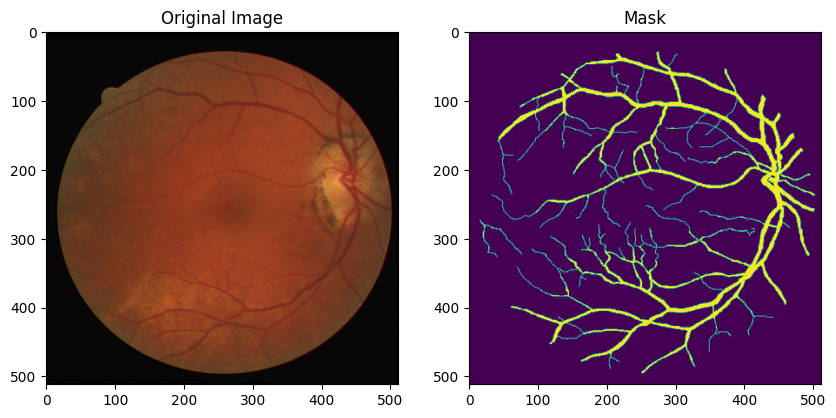

In [ ]:
img=Image.open('/content/retina-blood-vessel/Data/train/image/21.png')
mask=Image.open('/content/retina-blood-vessel/Data/train/mask/21.png')

print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Size:",img.size)

print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape)

print("Unique in Mask:",np.unique(mask))
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [ ]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)

    return reshaped_image

Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 20

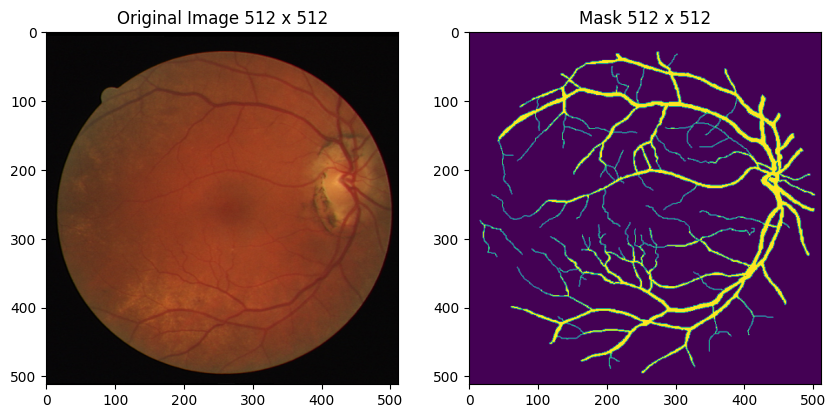

In [ ]:
# AFTER RESHAPE
img=reshape_to_512("/content/retina-blood-vessel/Data/train/image/21.png")
mask=reshape_to_512("/content/retina-blood-vessel/Data/train/mask/21.png")

print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Shape:",np.array(img).shape,"Mask Shape:",np.array(mask).shape,"Image dtype:",np.array(img).dtype,"Mask dtype:", np.array(mask).dtype)

print("Unique in Mask:",np.unique(mask))

print("Number of Ones in Mask:",np.sum(np.sum(np.array(mask)/255)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [ ]:
class TrainDataset(Dataset):
    def __init__(self,root_path,transform=None):
        super().__init__()
        self.root_path = root_path
        self.image_folder = os.path.join(root_path, 'image')
        self.mask_folder = os.path.join(root_path, 'mask')
        self.image_filepaths = sorted([os.path.join(self.image_folder, filename) for filename in os.listdir(self.image_folder) if filename.endswith('.png')])
        self.mask_filepaths = sorted([os.path.join(self.mask_folder, filename) for filename in os.listdir(self.mask_folder) if filename.endswith('.png')])
        self.length = min(len(self.image_filepaths), len(self.mask_filepaths))
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
      # /home/DL/UNet/Dataset -> /Train, /Test -> /Image, /Mask ->/1.png,/2.png.../72.png
        img_path = os.path.join(self.root_path, 'image', f"{idx}.png")
        # print(path)
        img=reshape_to_512(img_path)
        img=self.transform(img)

        mask_path = os.path.join(self.root_path, 'mask', f"{idx}.png")
        mask=reshape_to_512(mask_path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        # mask[mask==255]=1
        mask[mask != 0] = 1

        return img, mask

class ValDataset(Dataset):
    def __init__(self,root_path,transform=None):
        super().__init__()
        self.root_path = root_path
        self.image_folder = os.path.join(root_path, 'image')
        self.mask_folder = os.path.join(root_path, 'mask')
        self.image_filepaths = sorted([os.path.join(self.image_folder, filename) for filename in os.listdir(self.image_folder) if filename.endswith('.png')])
        self.mask_filepaths = sorted([os.path.join(self.mask_folder, filename) for filename in os.listdir(self.mask_folder) if filename.endswith('.png')])
        self.length = min(len(self.image_filepaths), len(self.mask_filepaths))
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])



    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        img_path = os.path.join(self.root_path, 'image', f"{idx}.png")
        # print(path)
        img=reshape_to_512(img_path)
        img=self.transform(img)

        mask_path = os.path.join(self.root_path, 'mask', f"{idx}.png")
        mask=reshape_to_512(mask_path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        # mask[mask==255]=1
        mask[mask != 0] = 1

        return img, mask

In [ ]:
train_dataset=TrainDataset("/content/retina-blood-vessel/Data/train")

#train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[16,4])

val_dataset=ValDataset("/content/retina-blood-vessel/Data/test")

batch_size=4

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

val_dataloader=DataLoader(dataset=val_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


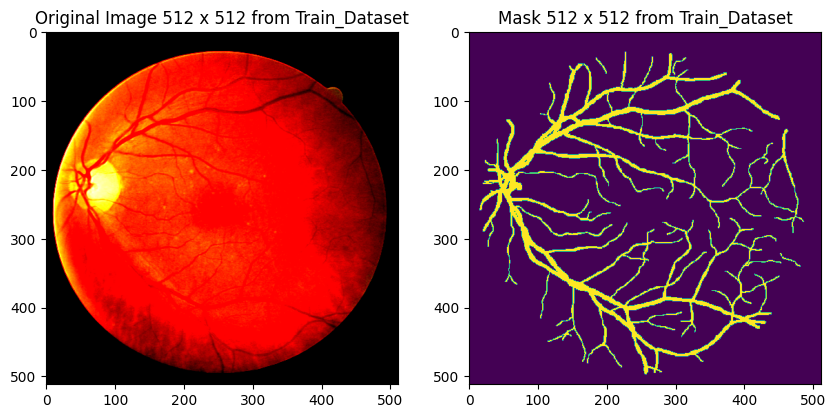

In [ ]:
img,mask=train_dataset[0]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [ ]:
class Unet(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder=encoder
        self.center=center
        self.decoder=decoder
        #self.dropout=nn.Dropout(p=0.2, inplace=True)

    def forward(self,x):
        encoder_features_outputs=self.encoder(x)
        #self.dropout(encoder_features_outputs[-1])
        center_output=self.center(encoder_features_outputs[-1])
        logits=self.decoder(center_output, encoder_features_outputs)
        return logits

In [ ]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network):
        super().__init__()
        self.encoder=pretrained_network

    def forward(self,x):
        encoder_features_outputs=[]
        for layer in self.encoder.features:
                x=layer(x)
                encoder_features_outputs.append(x)

        return encoder_features_outputs

In [ ]:
class Center(nn.Sequential):
  def __init__(self):
        conv1=nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3,padding=1)
        bn1=nn.BatchNorm2d(num_features=1024)
        rl1=nn.ReLU()

        conv2=nn.Conv2d(in_channels=1024,out_channels=1024, kernel_size=3,padding=1)
        bn2=nn.BatchNorm2d(num_features=1024)
        rl2=nn.ReLU()

        super().__init__(conv1,bn1,rl1,conv2,bn2,rl2)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.rl=nn.ReLU()

        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)

        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)

        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)

        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)

        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)

        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)

    def forward(self,x, encoder_features_output):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[42]),dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[32]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[22]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)

        logits=self.convfinal(x)

        return logits

In [ ]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    XintY=0
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs=imgs.to(device)
        masks=masks.to(device)

        preds=model(imgs)

        loss=loss_fn(preds,masks)

        track_loss+=loss.item()

        predclass=torch.argmax(preds,dim=1)

        Y+=predclass.sum().item()
        X+=masks.sum().item()


        predclass[predclass==0]=2

        XintY+=(predclass==masks).type(torch.float).sum().item()

        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)

        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef


def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)

            preds=model(imgs)

            loss=loss_fn(preds,masks)

            track_loss+=loss.item()

            predclass=torch.argmax(preds,dim=1)

            Y+=predclass.sum().item()
            X+=masks.sum().item()

            predclass[predclass==0]=2

            XintY+=(predclass==masks).type(torch.float).sum().item()

            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)


            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)

            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef

In [ ]:
pretrained_network=vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
print(pretrained_network)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 67.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# class IoULoss(nn.Module):
#     def __init__(self):
#         super(IoULoss, self).__init__()

#     def forward(self, inputs, targets):
#         smooth = 1.
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         intersection = (inputs * targets).sum()
#         union = inputs.sum() + targets.sum() - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         return 1 - iou

In [ ]:
for param in pretrained_network.features.parameters():
    param.requires_grad=False

encoder=Encoder(pretrained_network).to(device)
center=Center().to(device)
decoder=Decoder().to(device)

model=Unet(encoder,center, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()
#loss_fn = IoULoss()
lr=0.001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=40

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


# for param in pretrained_network.features.parameters():
#     param.requires_grad=True

# n_epochs=40
# for i in range(n_epochs):
#     print("Epoch No:",i+1)
#     train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
#     print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
#     val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
#     print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
#     print("--------------------------------------------------")

Epoch No: 1


RuntimeError: The size of tensor a (2097152) must match the size of tensor b (1048576) at non-singleton dimension 0

In [ ]:
def plotres(img,pred,mask=None):
    img[0,:,:]=img[0,:,:]*0.229 + 0.485
    img[1,:,:]=img[1,:,:]*0.224 + 0.456
    img[2,:,:]=img[2,:,:]*0.225 + 0.406
    if mask!=None:
        print("Image Shape:",img.shape,"Mask Shape:", mask.shape, "Pred Shape:",pred.shape, "Image dtype", img.dtype, "Mask dtype",mask.dtype, "Pred dtype",pred.dtype)
        print("Mask Unique:",mask.unique())
    else:
        print("Image Shape:",img.shape, "Pred Shape:", pred.shape, "Image dtype:",img.dtype, "Pred dtype:",pred.dtype)

    print("Pred Unique:",pred.unique())

    plt.figure(figsize=(10,5))

    plt.subplot(1,3,1)
    plt.title("Original Image 512 x 512")
    plt.imshow(torch.permute(img.cpu(),(1,2,0)))

    if mask!=None:
        plt.subplot(1,3,2)
        plt.title("Mask Image  512 x 512")
        plt.imshow(mask.cpu())

    plt.subplot(1,3,3)
    plt.title("Predicted Image  512 x 512")
    plt.imshow(pred.cpu())
    plt.show()

On Validation Set: 2*XintY: 219326.0 X: 138636 Y: 126475 X+Y: 265111
Validation Dice Coef: 0.83
Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


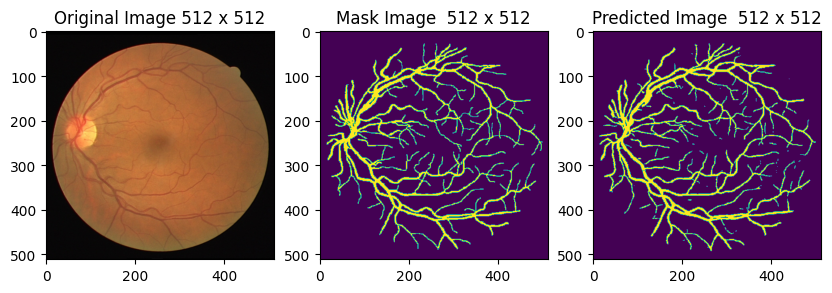

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


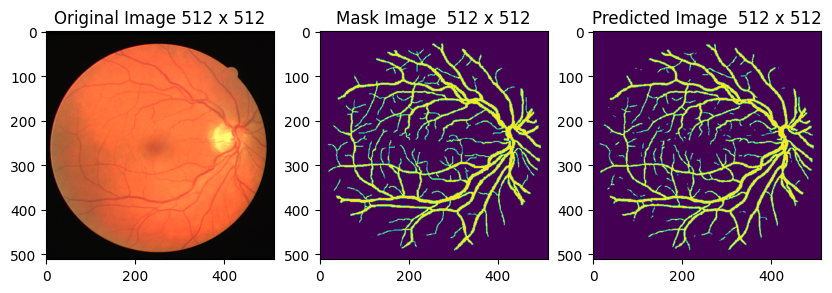

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


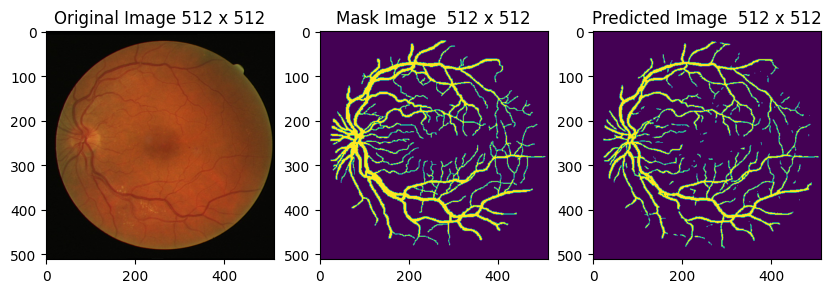

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


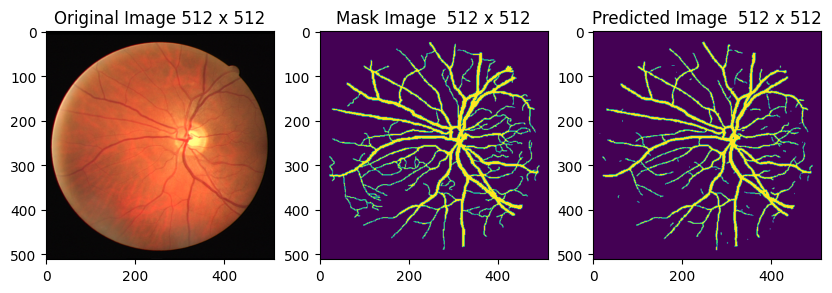

4


In [ ]:
imgs,masks=next(iter(val_dataloader))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)

    predclass=torch.argmax(preds,dim=1)

    Y=predclass.sum().item()
    X=masks.sum().item()

    predclass[predclass==0]=2

    XintY=(predclass==masks).type(torch.float).sum().item()

    print("On Validation Set:","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

    dice_coef=round((2*XintY)/(X+Y),2)


print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0
plotres(imgs[0],predclass[0],masks[0])
plotres(imgs[1],predclass[1],masks[1])
plotres(imgs[2],predclass[2],masks[2])
plotres(imgs[3],predclass[3],masks[3])
print(len(imgs))
# plotres(imgs[4],predclass[4],masks[4])
# plotres(imgs[5],predclass[5],masks[5])

In [ ]:
train_dataset=TrainDataset("/content/retina-blood-vessel/Data/train", "yes")

batch_size=4

n_epochs=40

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 234882.0 X: 122058 Y: 124708 X+Y: 246766
Training Batch 1 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 2 : 2*XintY: 477564.0 X: 249527 Y: 253976 X+Y: 503503
Training Batch 2 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 3 : 2*XintY: 709012.0 X: 370090 Y: 377109 X+Y: 747199
Training Batch 3 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 4 : 2*XintY: 952820.0 X: 500303 Y: 503172 X+Y: 1003475
Training Batch 4 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 5 : 2*XintY: 1185668.0 X: 624739 Y: 624029 X+Y: 1248768
Training Batch 5 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 6 : 2*XintY: 1431710.0 X: 755543 Y: 752739 X+Y: 1508282
Training Batch 6 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 7 : 2*XintY: 1648268.0 X: 868573 Y: 868281 X+Y: 1736854
Training Batch 7 : / 20 Running Loss: 0.03 Running Dice_Coef: 0.95
Trainig Batch 8 : 2*XintY: 1910834.0

In [ ]:
class TestDataset(Dataset):
    def __init__(self,root_path):
        self.root_path = root_path
        self.image_folder = os.path.join(root_path, 'image')
        self.mask_folder = os.path.join(root_path, 'mask')
        self.image_filepaths = sorted([os.path.join(self.image_folder, filename) for filename in os.listdir(self.image_folder) if filename.endswith('.png')])
        self.mask_filepaths = sorted([os.path.join(self.mask_folder, filename) for filename in os.listdir(self.mask_folder) if filename.endswith('.png')])
        self.length = min(len(self.image_filepaths), len(self.mask_filepaths))
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
      img_path = os.path.join(self.root_path, 'image', f"{idx}.png")
        # print(path)
      img=reshape_to_512(img_path)
      img=self.transform(img)
        # mask_path = os.path.join(self.root_path, 'mask', f"{idx}.png")
        # mask=reshape_to_512(mask_path)
        # mask=np.array(mask)
        # mask=torch.from_numpy(mask).type(torch.long)
        # # mask[mask==255]=1
        # mask[mask != 0] = 1

        # idx=idx+1
        # if idx <= 9:
        #     path=self.path + "0" + str(idx) + "_test.tif"
        # else:
        #     path=self.path + str(idx) + "_test.tif"

        # img=reshape_to_512(path)
        # img=self.transform(img)

      return img


In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_dataset=TestDataset("/content/retina-blood-vessel/Data/test")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


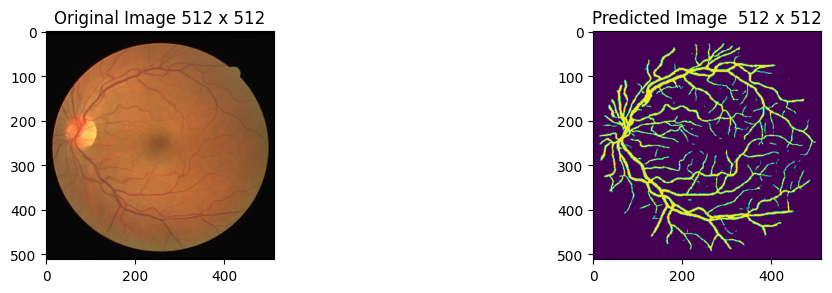

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


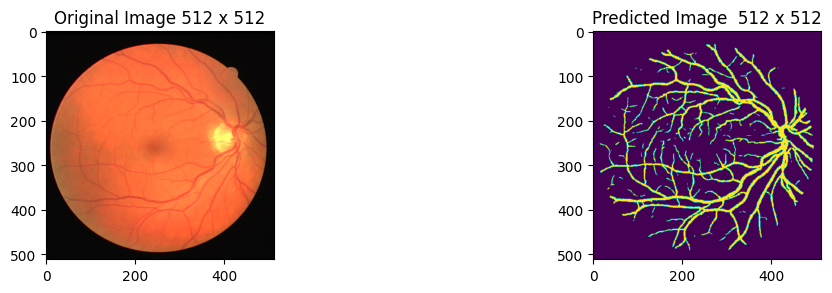

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


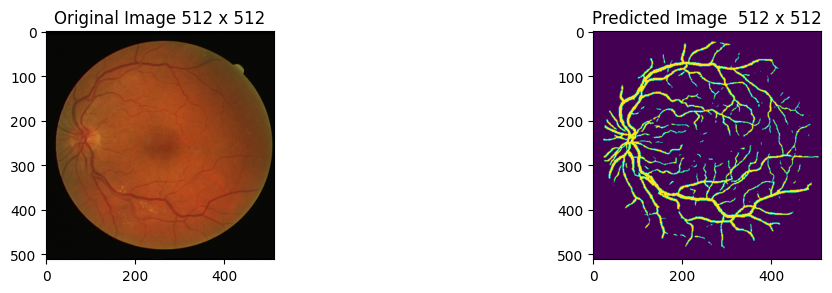

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


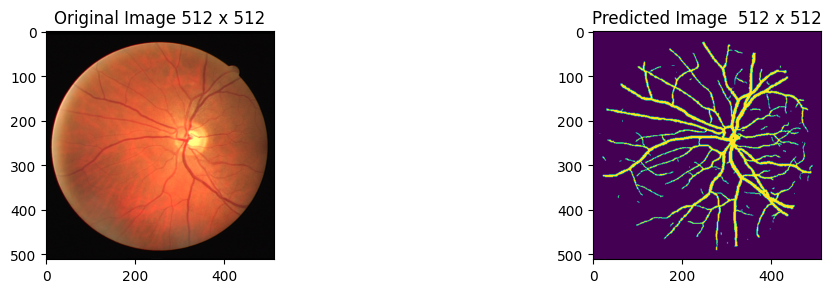

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


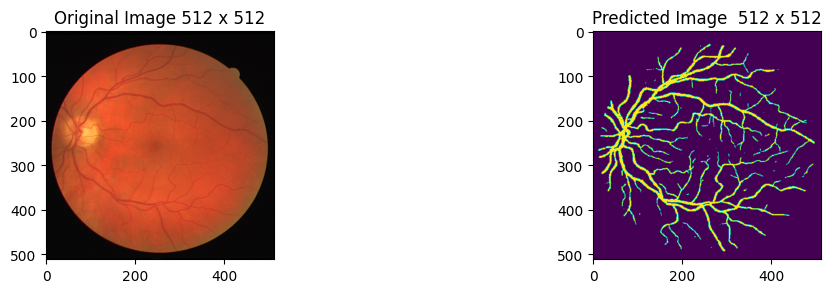

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


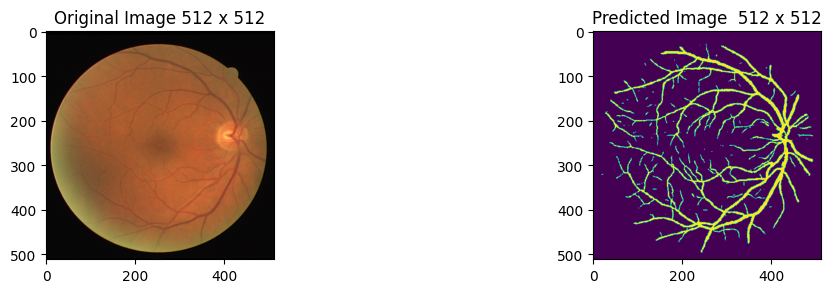

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


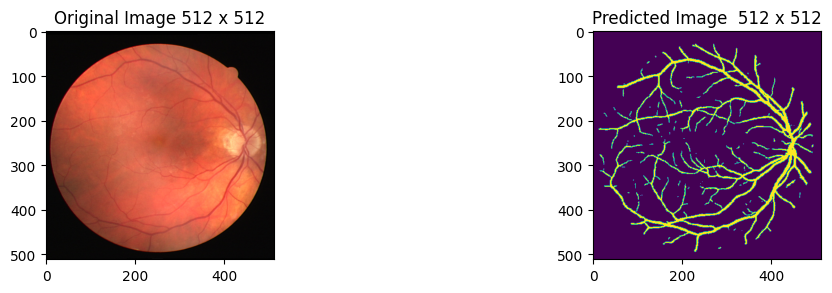

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


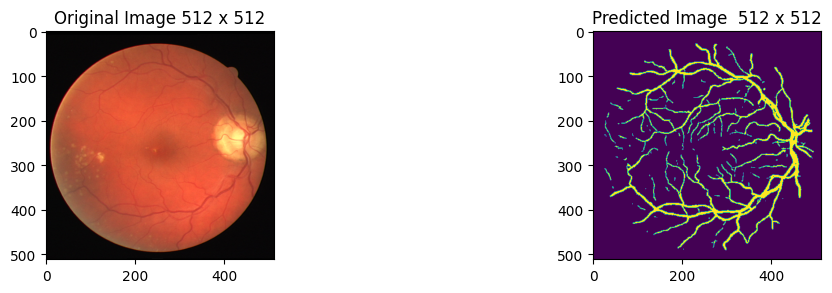

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


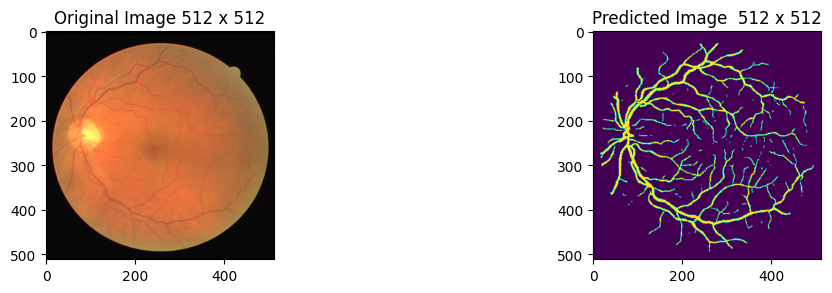

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


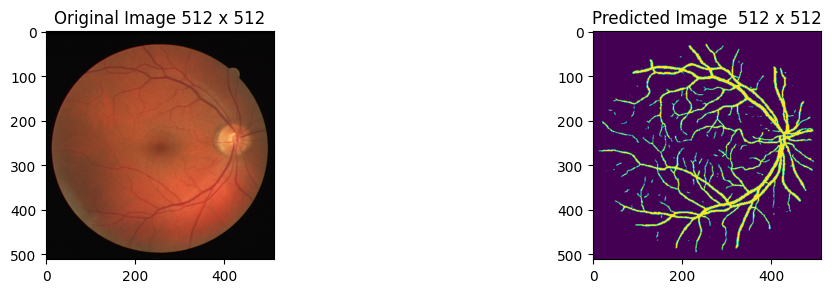

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


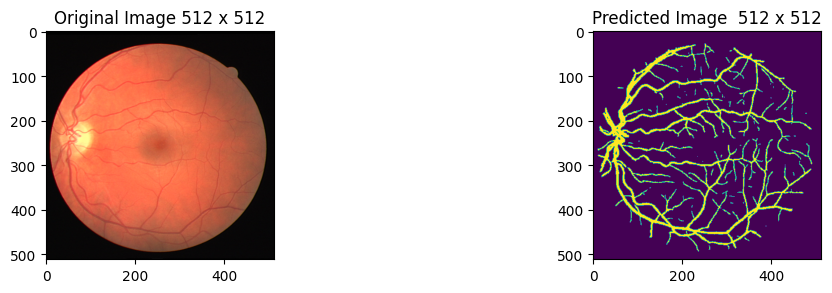

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


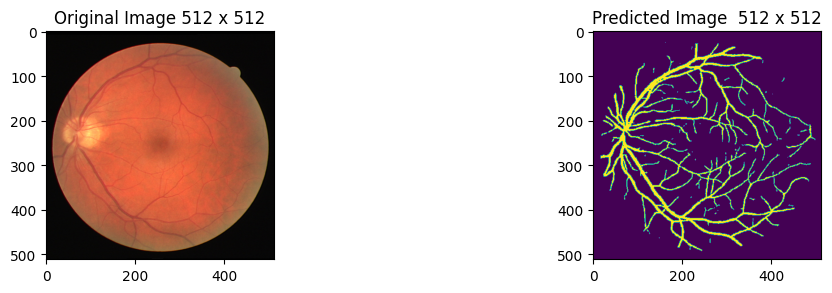

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


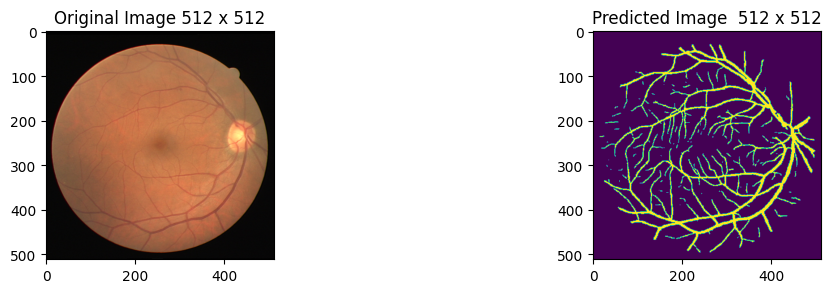

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


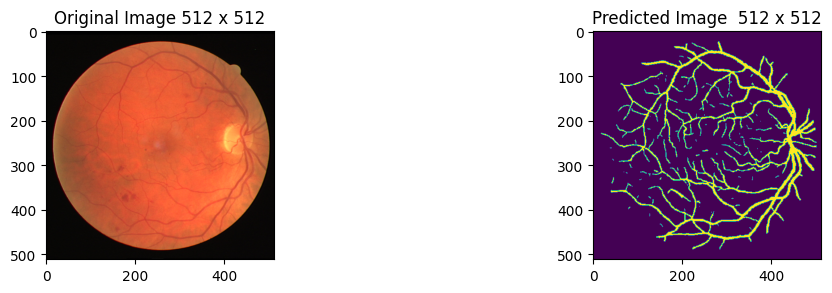

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


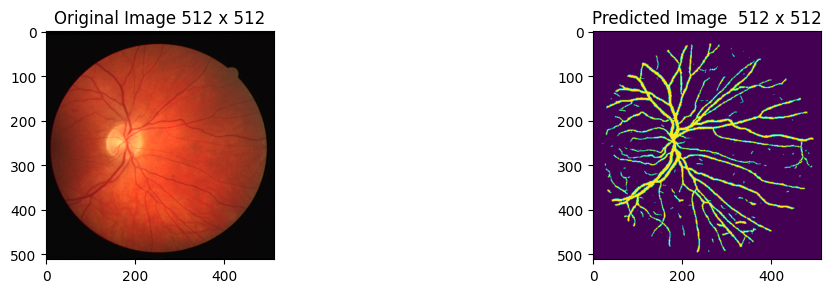

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


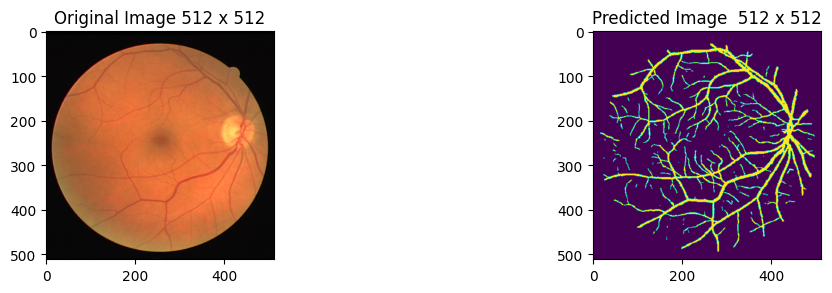

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


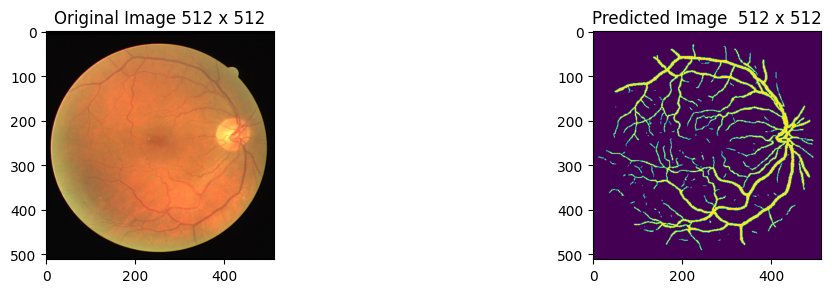

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


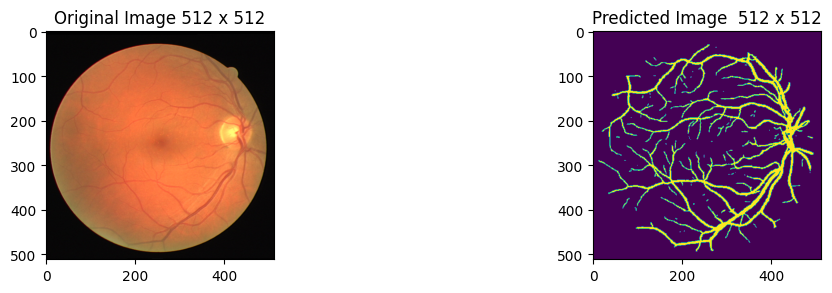

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


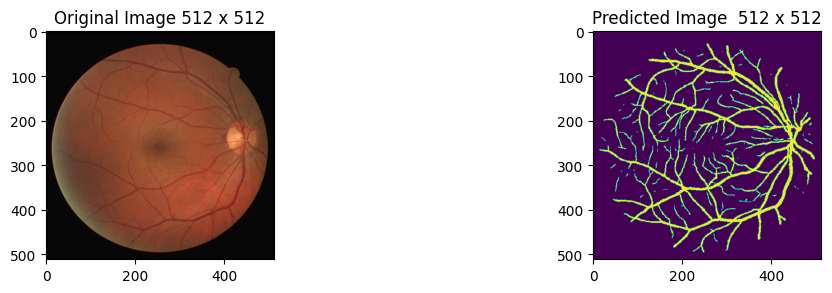

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


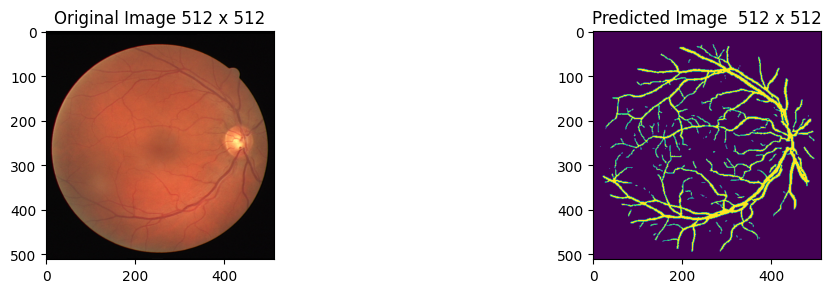

Id                                          Predicted
0    0  14597 2 14629 3 15078 1 15109 2 15139 5 15590 ...
1    1  15122 2 15615 7 15633 3 16127 9 16145 3 16639 ...
2    2  12044 2 12555 10 13066 12 13577 10 13598 6 140...
3    3  12537 2 13046 6 13558 6 14070 7 14583 6 15096 ...
4    4  15109 3 15620 5 16130 8 16626 1 16641 8 16675 ...
5    5  15102 2 15615 1 16113 1 16127 1 16639 1 16673 ...
6    6  15078 3 15119 2 15590 4 15631 2 16096 4 16102 ...
7    7  14567 4 15079 5 15122 5 15591 6 15633 7 16103 ...
8    8  14104 3 14576 4 14613 6 15089 4 15124 6 15601 ...
9    9  15102 3 15614 4 16126 4 16601 3 16638 5 17112 ...
10  10  14588 2 15099 4 15587 4 15612 3 16096 8 16124 ...
11  11  12963 1 14567 6 14617 2 15078 6 15128 3 15591 ...
12  12  15112 1 15583 3 15623 4 15645 1 16095 4 16135 ...
13  13  12058 2 12570 3 13081 4 13535 1 13593 5 14047 ...
14  14  14599 3 15110 5 15582 1 15622 4 15643 1 16093 ...
15  15  14600 5 15112 7 15624 8 16136 9 16172 1 16649 ...
16  16  15585 3 16097 3 16608 4 17120 4 17632 4 17702 ...
17  17  15618 5 16130 5 16641 6 17152 5 17662 6 18172 ...
18  18  14592 4 15104 5 15616 5 16128 6 16641 5 16685 ...
19  19  15630 2 16117 1 16142 2 16628 2 16655 2 17139 ...

In [ ]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)

        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()

                plotres(imgs[i],pred)

                predf=pred.flatten()

                pixelidx=np.where(predf==1)[0]+1

                run_lengths=[]

                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid

                output = ' '.join([str(r) for r in run_lengths])

                outputs.append(output)
    return outputs

outputs=eval_one_epoch(test_dataloader,model)
df=pd.DataFrame(columns=['Id','Predicted'])
df['Id']=[str(i) for i in range(20)]
df['Predicted']=outputs
df.to_csv("submission.csv", index=None)
df